# **声優統計コーパスの学習コード**

In [ ]:
!pip install -U efficientnet -qq

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import glob
import os
import cv2

import IPython.display as ipd 

import librosa 
import librosa.display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import efficientnet.tfkeras as efn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
df = pd.DataFrame(columns=["path","spc_path", "label"])
dirPathPattern = "/content/drive/MyDrive/voice_corpus/*/*.wav"
for path in glob.glob(dirPathPattern):
  filePath = path
  label = path.split("/")[-1].split("_")[1]
  spc_name = "/content/drive/MyDrive/spectrogram/" + path.split("/")[-1][:-4]
  spc_path = "/content/drive/MyDrive/spectrogram/" + path.split("/")[-1][:-4] + ".npy"
  signal, sr = librosa.load(path)
  if len(signal) >= 99225:
    signal = signal[:99225] #22050 *4.5

  x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
  x2 = librosa.power_to_db(x1, ref=np.max)
  np.save(spc_name, x2)
  df = df.append({'path': path,'spc_path': spc_path, 'label': label}, ignore_index=True)



In [ ]:
df.head()

In [ ]:
signal, sr = librosa.load("/content/drive/MyDrive/voice_corpus/fujitou_angry/fujitou_angry_005.wav")
print(signal.shape)
print(sr)
print(len(signal) / sr)

(325458,)
22050
14.76


In [ ]:
x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
x2 = librosa.power_to_db(x1, ref=np.max)   

print(x2.shape)

librosa.display.specshow(x2, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

In [ ]:
labels = np.unique(df.label.values)
label_encoder = {label:i for i, label in enumerate(labels)}
label_decoder = {0:"angry", 1:"happy", 2:"normal"}

(8, 128, 194, 3)
[2. 2. 2. 2. 2. 2. 2. 2.]


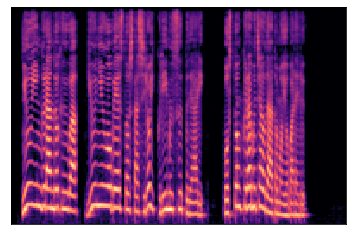

In [ ]:
IMG_SIZE = (128,194)
#(128, 194)
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, shuffle=True, is_train=True):
        self.df = df
        self.n = len(df)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_train = is_train
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle == True:
            np.random.shuffle(self.indices)   
    
    def __len__(self):
        
        return math.ceil( self.n / self.batch_size )
    
    def __getitem__(self, batch_index):
        
        start = batch_index * self.batch_size
        end = (batch_index + 1) * self.batch_size
        
        indices = self.indices[start:end]
        
        return self.__data_generation(indices)
    
    def __data_generation(self, batch_indices):
        batch_size = len(batch_indices)
        
        X = np.zeros(shape=(batch_size, IMG_SIZE[0], IMG_SIZE[1], 3))
        y = np.zeros(batch_size)
        
        for i, idx in enumerate(batch_indices):
            path = self.df.spc_path.values[idx]
            LABEL = self.df.label.values[idx]
            
            # SET = 'train_spec' if self.is_train else 'test_spec'
            # path = f'{SPEC_PATH}/{SET}/{FILE[:-4]}.npy'

            try:
                data_array = np.load(path)
                resized = cv2.resize(data_array, (IMG_SIZE[1], IMG_SIZE[0]))
                
                for j in range(3):
                    X[i,:,:,j] = resized 
                
            except:
                print('skipped')

            if self.is_train:
                y[i] = label_encoder[LABEL]

        if self.is_train:    
            return X, y
        return X

    
GENERATOR_TEST = True

if GENERATOR_TEST:
    temp_gen = DataGenerator(df, batch_size=8, shuffle=False)
    X,y = temp_gen.__getitem__(0)

    print(X.shape)
    print(y)
    
    librosa.display.specshow(X[0, :, :, 0])

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df.label)

print(train_df.shape)
print(valid_df.shape)

(720, 3)
(180, 3)


In [ ]:
train_loader = DataGenerator(train_df, batch_size=32, shuffle=True)
valid_loader = DataGenerator(valid_df, batch_size=32, shuffle=False)

In [ ]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

23
6


**モデル作成・学習**

In [ ]:
ENB1_model = efn.EfficientNetB1(input_shape=(128,194,3), include_top=False, weights='imagenet')
ENB1_model.trainable = True

27172864/27164032 [==============================] - 2s 0us/step


In [ ]:
cnn = Sequential([
    ENB1_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.45),
    
    Dense(32, activation='relu'),
    Dropout(0.45),
    
    Dense(3, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functional  (None, 4, 7, 1280)       6575232   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 35840)             0         
                                                                 
 dense (Dense)               (None, 64)                2293824   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
h1 = cnn.fit(train_loader, steps_per_epoch = TR_STEPS, epochs = 30, validation_data = valid_loader, 
             validation_steps = VA_STEPS, verbose = 1)

cnn.save(f'/content/drive/MyDrive/model/audio_emotion_v01.h5')

In [ ]:
def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

history = merge_history([h1])
vis_training(history, start=10)

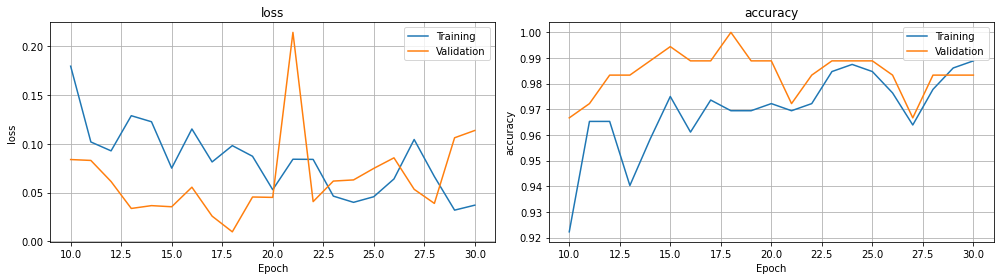

In [ ]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

history = merge_history([h1])
vis_training(history, start=10)

**データセットで検証**

In [ ]:
path = "/content/drive/MyDrive/voice_corpus/tsuchiya_happy/tsuchiya_happy_004.wav"
path = "/content/drive/MyDrive/voice_corpus/tsuchiya_angry/tsuchiya_angry_004.wav"
ipd.Audio(path)

In [ ]:
df

In [ ]:
signal, sr = librosa.load(path)
if len(signal) <= 99225:
  signal = signal[:99225] #22050 *4.5

x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
x2 = librosa.power_to_db(x1, ref=np.max)


IMG_SIZE = (128,194)

X = np.zeros(shape=(1, IMG_SIZE[0], IMG_SIZE[1], 3))

resized = cv2.resize(x2, (IMG_SIZE[1], IMG_SIZE[0]))

for j in range(3):
    X[0,:,:,j] = resized
     
        
              

In [ ]:
y_test = cnn.predict(X)
print(label_decoder[np.argmax(y_test)])

angry
